In [1]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

In [2]:
import requests

In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

In [7]:
def draw_box(pred_class, img, rect_th=2, text_size=0.5, text_th=2, download_image=False, img_name="img"):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """
    image = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for predicted_class in pred_class:
      
      label=predicted_class[0]
      probability=predicted_class[1]
      box=predicted_class[2]
      t = round(box[0][0].tolist())
      l = round(box[0][1].tolist())
      r = round(box[1][0].tolist())
      b = round(box[1][1].tolist())

      # Giving brief information about rectange, class and probability.
      from colorama import Fore
      from colorama import Style
      print(f"\nLabel: {Fore.GREEN}{label}{Style.RESET_ALL}")
      print(f"Box coordinates: {t}, {l}, {r}, {b}")
      print(f"Probability: {probability}")

      # Drawing rectangle and adding text on the picture based on their class and size.
      cv2.rectangle(image, (t, l), (r, b), (0, 255, 0), rect_th)
      cv2.rectangle(image, (t, l), (t+110, l+17), (255, 255, 255), -1)
      cv2.putText(image, label, (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX, 
                  text_size, (0,255,0), thickness=text_th)
      cv2.putText(image, label+": "+str(round(probability, 2)), 
                  (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size, 
                  (0, 255, 0),thickness=text_th)

    # Plotting image
    image = np.array(image)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if download_image:
      plt.savefig(f'{img_name}.png')
    else:
      pass
    plt.show()
    
    del(img)
    del(image)

In [8]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

<br>

<a id="load_faster_rcnn"></a>

<h2 align=center>Load Pre-trained Faster R-CNN</h2>

In [9]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

done


In [10]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

Common classes listed below


In [11]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

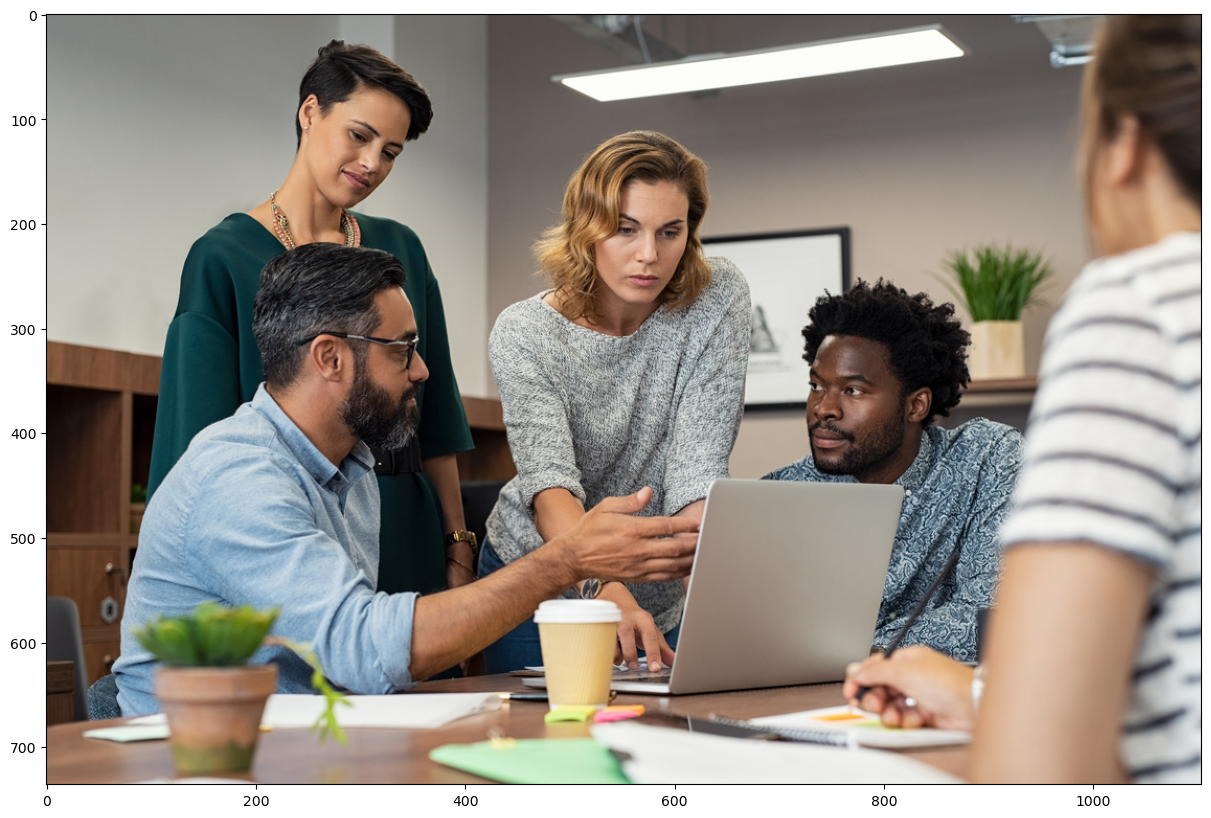

In [12]:
img_path='business-people.jpg'
half = 0.5
image = Image.open(img_path)

image.resize([int(half * s) for s in image.size] )
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

<p>We will create a transform object to convert the image to a tensor.</p>


In [13]:
transform = transforms.Compose([transforms.ToTensor()])

In [14]:
img = transform(image)

<p>Let's print out our image:</p>

In [15]:
img

tensor([[[0.4980, 0.5020, 0.5020,  ..., 0.3216, 0.3255, 0.3294],
         [0.5059, 0.5020, 0.4980,  ..., 0.3294, 0.3333, 0.3412],
         [0.5098, 0.5059, 0.4980,  ..., 0.3412, 0.3451, 0.3490],
         ...,
         [0.6039, 0.6039, 0.6039,  ..., 0.8784, 0.8784, 0.8784],
         [0.6039, 0.6039, 0.6078,  ..., 0.8784, 0.8784, 0.8784],
         [0.6078, 0.6118, 0.6157,  ..., 0.8745, 0.8745, 0.8745]],

        [[0.5059, 0.5098, 0.5098,  ..., 0.2706, 0.2745, 0.2784],
         [0.5137, 0.5098, 0.5059,  ..., 0.2784, 0.2824, 0.2902],
         [0.5176, 0.5137, 0.5059,  ..., 0.2863, 0.2902, 0.2941],
         ...,
         [0.4431, 0.4431, 0.4431,  ..., 0.8941, 0.8941, 0.8941],
         [0.4431, 0.4431, 0.4471,  ..., 0.8941, 0.8941, 0.8941],
         [0.4471, 0.4510, 0.4549,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.5020, 0.5059, 0.5059,  ..., 0.2392, 0.2431, 0.2471],
         [0.5098, 0.5059, 0.5020,  ..., 0.2471, 0.2510, 0.2549],
         [0.5137, 0.5098, 0.5020,  ..., 0.2510, 0.2549, 0.

In [16]:
pred = model([img])

In [17]:
len(pred[0]['labels'])

51

In [18]:
pred[0]['labels']

tensor([ 1,  1,  1, 73,  1, 62, 47, 64,  1, 64, 67, 72, 67, 67, 67,  1, 86,  1,
        62, 32, 64, 67, 62, 84, 49, 84,  1,  1,  1, 49, 50, 62, 67, 15, 67, 49,
        62, 84, 67,  1, 67,  1,  1, 84, 86, 67, 67, 72, 77, 62, 63])

In [19]:
pred[0]['scores']

tensor([0.9965, 0.9951, 0.9935, 0.9923, 0.9895, 0.9873, 0.9743, 0.9720, 0.9289,
        0.8908, 0.7935, 0.7412, 0.7377, 0.6966, 0.6759, 0.5434, 0.3902, 0.3585,
        0.3384, 0.3225, 0.3049, 0.2773, 0.2054, 0.1730, 0.1729, 0.1692, 0.1612,
        0.1505, 0.1488, 0.1483, 0.1437, 0.1230, 0.1132, 0.1113, 0.1085, 0.1059,
        0.0993, 0.0975, 0.0914, 0.0811, 0.0774, 0.0757, 0.0691, 0.0636, 0.0633,
        0.0622, 0.0605, 0.0588, 0.0582, 0.0573, 0.0544])

<p>The class number corresponds to the index of the list with the corresponding  category name.</p>


In [20]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [21]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[400.628173828125, 117.69422149658203, 681.774169921875, 608.8928833007812]

<p>These components correspond to the top-left corner and bottom-right corner of the rectangle, more precisely: <b>top(t), left(l), bottom(b), right(r).</b></p>

<p>We need to round them, otherwise we can't show it on picure.</p>

In [22]:
t, l, r, b = [round(x) for x in bounding_box]
print(t, l, r, b)

401 118 682 609


We convert the tensor to an OpenCV array and plot an image with the box:


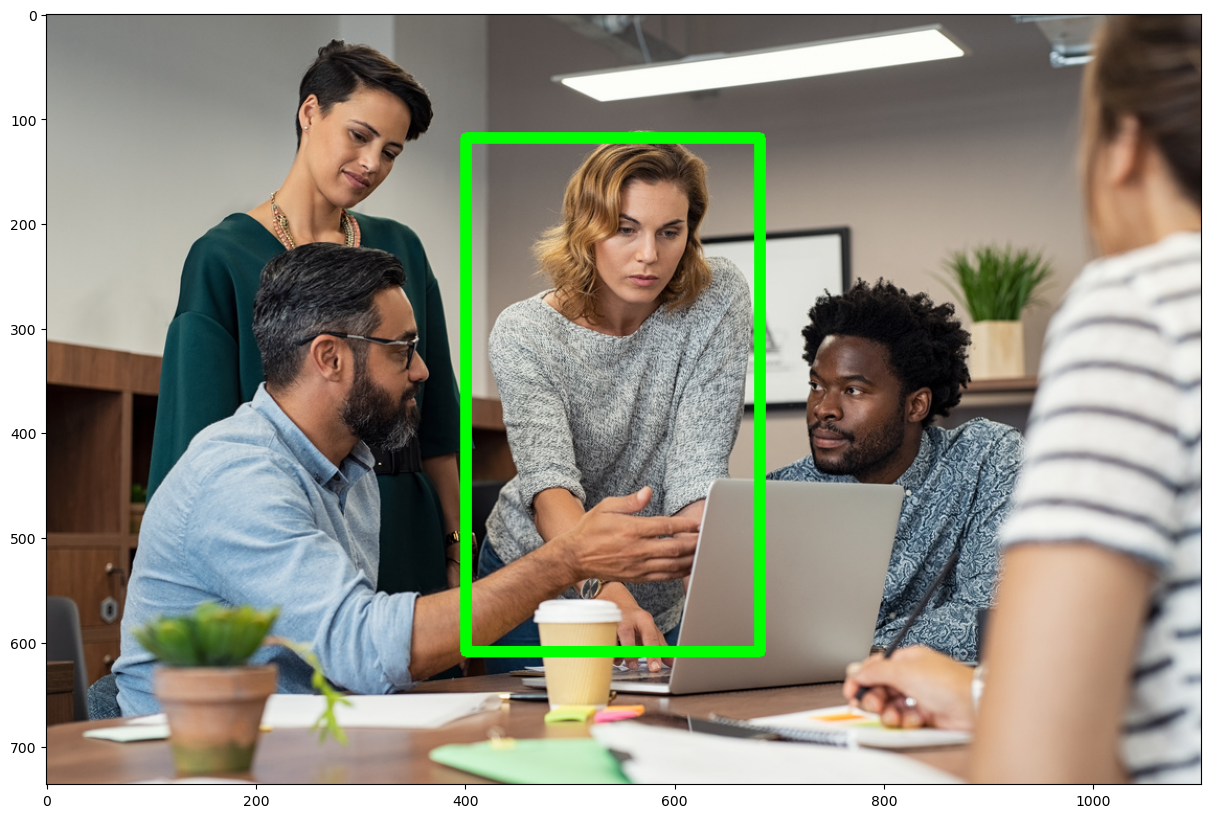

In [23]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8)
cv2.rectangle(img_plot, (t, l), (r, b), (0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b


Label: person
Box coordinates: 401, 118, 682, 609
Probability: 0.9964801669120789

Label: person
Box coordinates: 872, 7, 1096, 724
Probability: 0.9951039552688599

Label: person
Box coordinates: 59, 169, 537, 693
Probability: 0.9935211539268494

Label: person
Box coordinates: 645, 257, 945, 681
Probability: 0.989526629447937

Label: person
Box coordinates: 70, 16, 413, 512
Probability: 0.9289109110832214


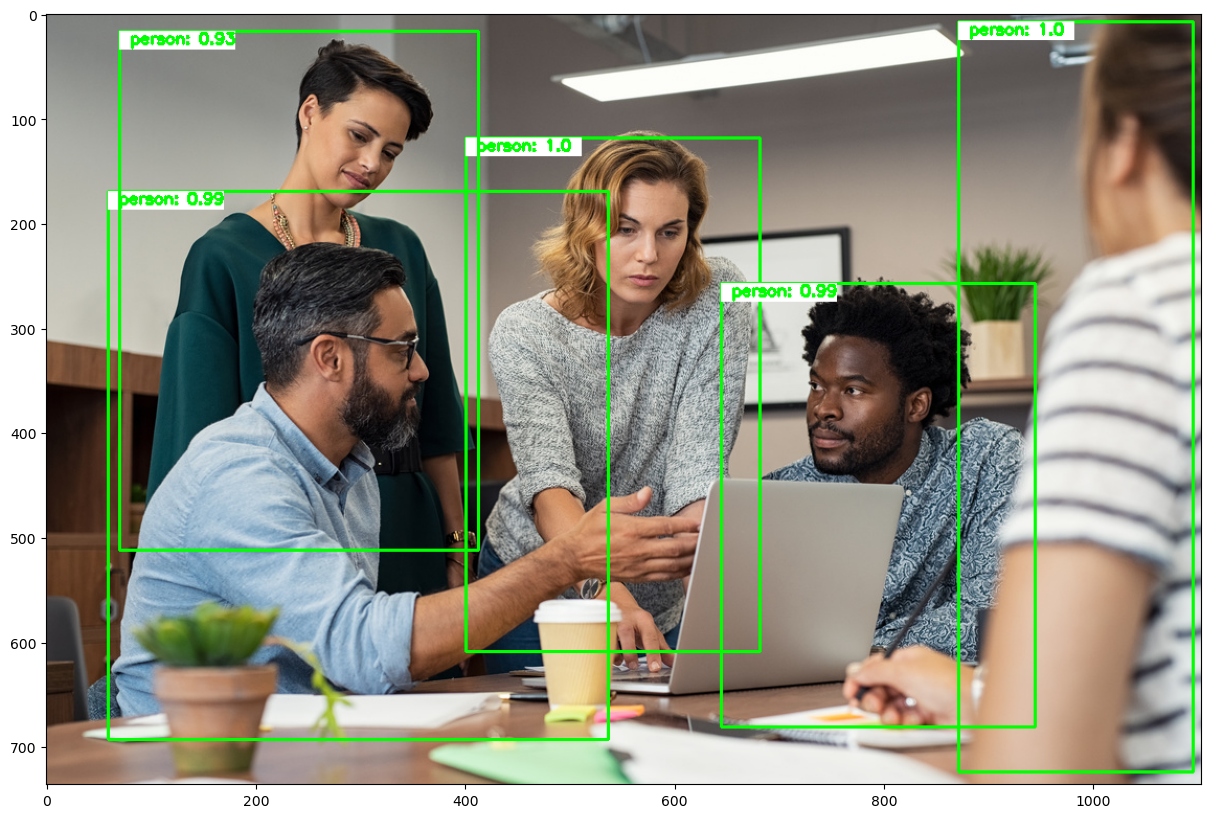

In [24]:
pred_class=get_predictions(pred, objects="person")
draw_box(pred_class, img)

del pred_class

We can set a threshold <code>threshold</code>. Here we set the  threshold 1 i.e Here we set the  threshold 1 i.e. 100% likelihood.


In [25]:
get_predictions(pred, threshold=1, objects="person")

[]


Label: person
Box coordinates: 401, 118, 682, 609
Probability: 0.9964801669120789

Label: person
Box coordinates: 872, 7, 1096, 724
Probability: 0.9951039552688599

Label: person
Box coordinates: 59, 169, 537, 693
Probability: 0.9935211539268494

Label: person
Box coordinates: 645, 257, 945, 681
Probability: 0.989526629447937


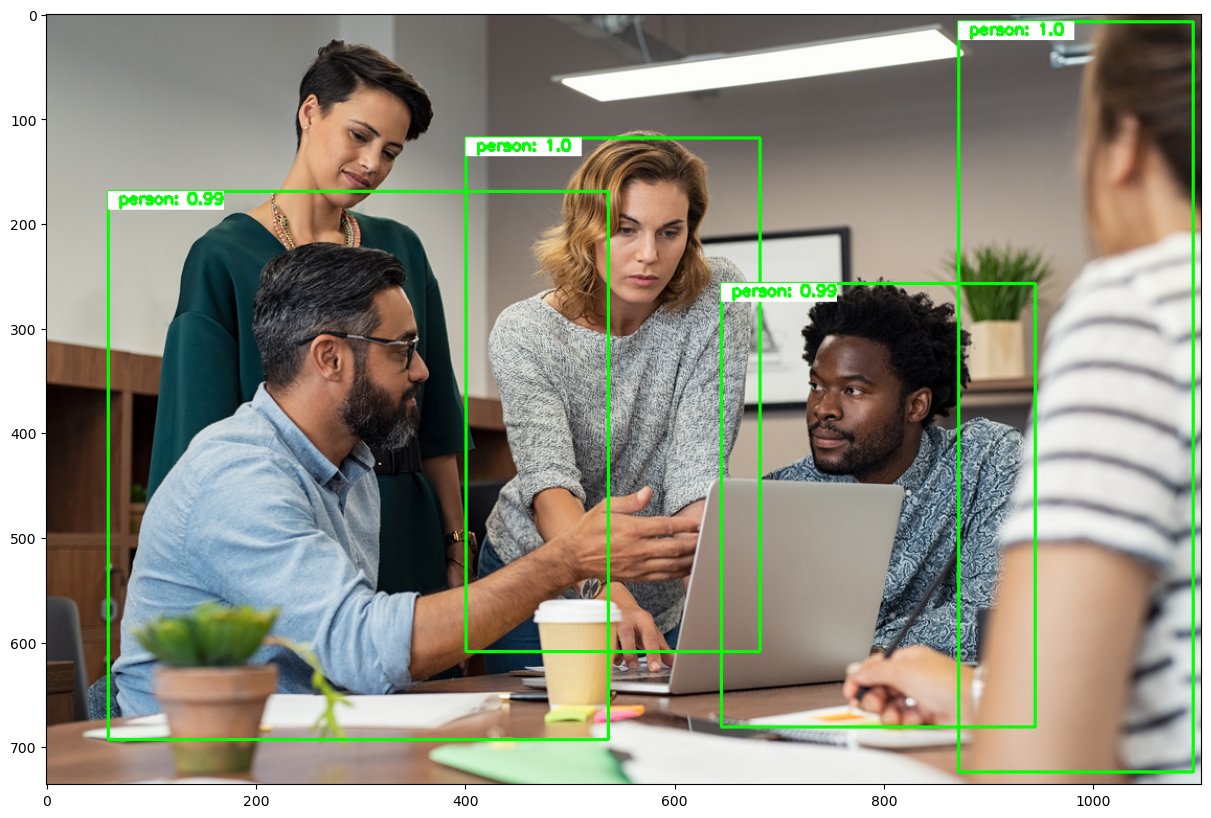

In [26]:
pred_thresh=get_predictions(pred, threshold=0.98, objects="person")
draw_box(pred_thresh, img, download_image=True, img_name="andrew_BOX")
del pred_thresh

In [27]:
save_RAM(image_=True)